# Incidence de la varicelle

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import os
import urllib.request

Les données de l'incidence de la varicelle sont disponibles du site Web du Réseau Sentinelles. Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1991 et se termine avec une semaine récente.

In [2]:
data_url = "https://www.sentiweb.fr/datasets/incidence-PAY-7.csv"

Il se peut que l'URl change et devienne caduque au fil du temps. Ce fichier va d'abord tenter d'importer une copie locale si elle est disponible, sinon charger l'URL et créer le fichier.

In [3]:
filename = "./varicelle.csv"

if not os.path.exists(filename):
    urllib.request.urlretrieve(data_url, filename)

raw_data = pd.read_csv(filename, skiprows=1)
raw_data.head()

week  indicator   inc  inc_low  inc_up  inc100  inc100_low  inc100_up  \
0  202017          7   147        0     410       0           0          0   
1  202016          7   758       78    1438       1           0          2   
2  202015          7  1918      675    3161       3           1          5   
3  202014          7  3879     2227    5531       6           3          9   
4  202013          7  7326     5236    9416      11           8         14   

  geo_insee geo_name  
0        FR   France  
1        FR   France  
2        FR   France  
3        FR   France  
4        FR   France

Y a t-il des points manquants dans ce jeu de données ? Non, parfait ! 

In [6]:
raw_data[raw_data.isnull().any(axis=1)]
data = raw_data.copy()

Nos données utilisent une convention inhabituelle: le numéro de semaine est collé à l'année, donnant l'impression qu'il s'agit de nombre entier. C'est comme ça que Pandas les interprète.

Un deuxième problème est que Pandas ne comprend pas les numéros de semaine. Il faut lui fournir les dates de début et de fin de semaine. Nous utilisons pour cela la bibliothèque isoweek.

Comme la conversion des semaines est devenu assez complexe, nous écrivons une petite fonction Python pour cela. Ensuite, nous l'appliquons à tous les points de nos donnés. Les résultats vont dans une nouvelle colonne 'period'.

In [7]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

Il restent deux petites modifications à faire.

Premièrement, nous définissons les périodes d'observation comme nouvel index de notre jeux de données. Ceci en fait une suite chronologique, ce qui sera pratique par la suite.

Deuxièmement, nous trions les points par période, dans le sens chronologique.

In [8]:
sorted_data = data.set_index('period').sort_index()

Nous vérifions la cohérence des données. Entre la fin d'une période et le début de la période qui suit, la différence temporelle doit être zéro, ou au moins très faible. Nous laissons une "marge d'erreur" d'une seconde.

Ici, aucun souci de ce coté !

In [9]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

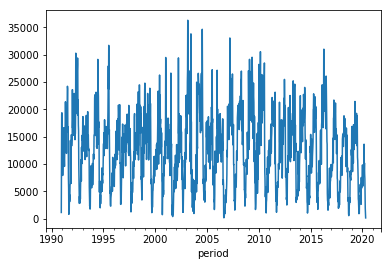

In [10]:
sorted_data['inc'].plot()

Prenons seulement un échantillon de ce graphe pour voir les pics d'incidence plus en détail.

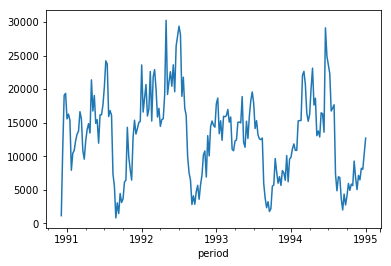

In [12]:
subset = sorted_data[sorted_data["week"] < 199500]
subset['inc'].plot()

Pour obtenir des résultats fiables, nous coupons les années entre les minimas des pics d'incidences, du 1er septembre de l'année  𝑁  au 1er septembre de l'année  𝑁+1 comme on peut le voir ici.

Notre tâche est un peu compliquée par le fait que l'année ne comporte pas un nombre entier de semaines. Nous modifions donc un peu nos périodes de référence: à la place du 1er août de chaque année, nous utilisons le premier jour de la semaine qui contient le 1er août.

Comme l'incidence de la varicelle est très faible en septembre, cette modification ne risque pas de fausser nos conclusions.

Encore un petit détail: les données commencent an octobre 1991, ce qui rend la première année incomplète. Nous commençons donc l'analyse en 1992.

In [13]:
first_august_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1992,
                                    sorted_data.index[-1].year)]

En partant de cette liste des semaines qui contiennent un 1er août, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.

Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [14]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_august_week[:-1],
                        first_august_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

Voici les incidences annuelles, d'une part sur une graphe et d'autre part sur une liste. On voit que l'année où le pic d'incidence est le moins élevé est en 2002, et le pic d'incidence le plus élevé en 2009.

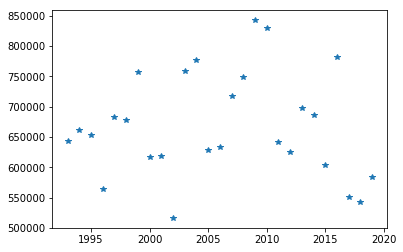

In [15]:
yearly_incidence.plot(style='*')

In [16]:
yearly_incidence.sort_values()

2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
2009    842373
dtype: int64